## Import

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import randint
from tqdm import tqdm
from PIL import Image

## Define Constants

In [ ]:
IN_SHAPE = (28,28,1)
LATENT_SHAPE = (10,)

## Load MNIST Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1,28,28,1))
x_test = x_test.reshape((-1,28,28,1))
x_train = x_train/255
x_test = x_test/255

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
def discr(in_shape = (28,28,1)):
  ''' Discriminator Model of GAN.
      Returns 1d output
  '''
  input = tf.keras.layers.Input(shape=in_shape)
  x = tf.keras.layers.Conv2D(32,(3,3),strides=(2,2), padding = 'same')(input)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2D(64,(3,3),strides=(2,2), padding = 'same')(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
  model = tf.keras.Model(input,x)
  model.compile(loss="BinaryCrossentropy", optimizer='adam', metrics=['accuracy'])
  return model

d = discr()
d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 re_lu (ReLU)                (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 re_lu_1 (ReLU)              (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1)                 3137  

In [ ]:
def gen(in_shape=LATENT_SHAPE, n_nodes = 14 * 14):
  ''' Generator Model of GAN
      Input Shape is shape of latent vector
      n_nodes is number of nodes for the first Dense Layer
  '''
  input = tf.keras.layers.Input(shape=in_shape)
  x = tf.keras.layers.Dense(n_nodes)(input)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Reshape((7,7,-1))(x)
  x = tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2), padding ='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2DTranspose(32,(3,3),strides=(2,2), padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2D(1,(1,1), padding = 'same', activation = 'sigmoid')(x)

  model = tf.keras.Model(input,x)
  return model

g = gen()
g.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 196)               2156      
                                                                 
 re_lu_2 (ReLU)              (None, 196)               0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       2368      
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                             

In [ ]:
def gan(gen, discr, in_shape = LATENT_SHAPE):
  ''' Stacking Generator and discriminator
  '''
  discr.trainable = False
  input = tf.keras.layers.Input(shape=in_shape)
  x = gen(input)
  x = discr(x)
  model = tf.keras.Model(input, x)
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

In [ ]:
def generate_real_samples(dataset, n_samples, use_continues = True):
  ''' Takes n_samples randomly from the dataset
      use_continues indicates whether y values should be discrete or continues
      if use_continues = True accuracy Metric will be 0 in training for the discr
  '''
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  if not use_continues:
    y = np.ones((n_samples, 1))
  if use_continues:
    y = np.random.uniform(low=0.7, high=1, size=(n_samples,1))
  return X, y

def generate_latent_points(latent_dim, n_samples):
  ''' Generates n_samples time the latent vector
  '''
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

def generate_fake_samples(gen, latent_dim, n_samples, use_continues = True):
  ''' Generates n_samples of fake images from the latent vector
      gen is reference to the generator to use
      use_continues indicates whether y values should be discrete or continues.
      if use_continues = True accuracy Metric will be 0 in training for the discr
  '''
  x_input = generate_latent_points(latent_dim, n_samples)
  X = gen.predict(x_input)
  if not use_continues:
    y = np.zeros((n_samples, 1))
  if use_continues:
    y = np.random.uniform(low=0, high=0.3, size=(n_samples,1))
  return X, y

In [ ]:
def train(gen, discr, gan, dataset, latent_dim = LATENT_SHAPE[0], epochs=10, n_batch=256):
  ''' Training function for training the generator against the discriminator
      gen = generator model
      discr = discriminator model
      gan = gan model
  '''
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for epoch in range(epochs):
      for batch in range(bat_per_epo):

            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(gen, latent_dim, half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss = discr.train_on_batch(X, y, return_dict = True)

            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan.train_on_batch(X_gan, y_gan)

      print('Epoch: ' + str(epoch) + " Discr Loss: " + str(d_loss) + " Gen Loss: " + str(g_loss))

In [ ]:
d = discr()
g = gen()
gan_model = gan(g, d)
train(g, d, gan_model, x_train, epochs = 40)
g.save("mnist_gen.h5")

Epoch: 0 Discr Loss: {'loss': 0.4785081744194031, 'accuracy': 0.0} Gen Loss: 1.1596744060516357
Epoch: 1 Discr Loss: {'loss': 0.4875577986240387, 'accuracy': 0.0} Gen Loss: 1.7033096551895142
Epoch: 2 Discr Loss: {'loss': 0.4888148009777069, 'accuracy': 0.0} Gen Loss: 1.4922221899032593
Epoch: 3 Discr Loss: {'loss': 0.511043906211853, 'accuracy': 0.0} Gen Loss: 1.574686050415039
Epoch: 4 Discr Loss: {'loss': 0.4848032593727112, 'accuracy': 0.0} Gen Loss: 1.3911914825439453
Epoch: 5 Discr Loss: {'loss': 0.489146888256073, 'accuracy': 0.0} Gen Loss: 1.6813154220581055
Epoch: 6 Discr Loss: {'loss': 0.47942620515823364, 'accuracy': 0.0} Gen Loss: 1.4519011974334717
Epoch: 7 Discr Loss: {'loss': 0.484055757522583, 'accuracy': 0.0} Gen Loss: 1.4465854167938232
Epoch: 8 Discr Loss: {'loss': 0.49946239590644836, 'accuracy': 0.0} Gen Loss: 1.4561023712158203
Epoch: 9 Discr Loss: {'loss': 0.5213046073913574, 'accuracy': 0.0} Gen Loss: 1.5223506689071655
Epoch: 10 Discr Loss: {'loss': 0.534081935

Epoch: 39 Discr Loss: {'loss': 0.5429933071136475, 'accuracy': 0.0} Gen Loss: 1.3021435737609863


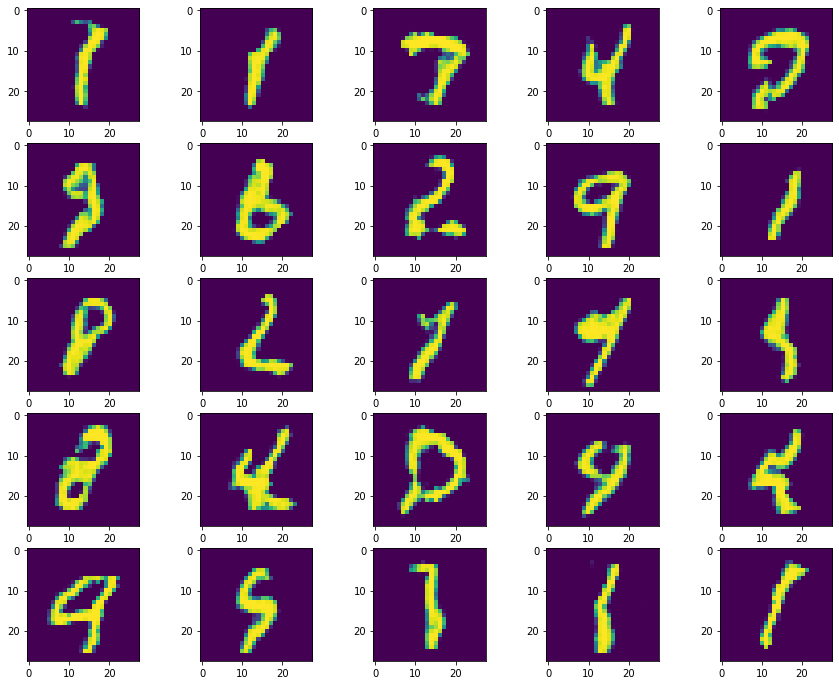

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 12))
axs = axs.ravel()

for i in range(25):
    latent_points = generate_latent_points(LATENT_SHAPE[0],1)
    pred = g.predict(latent_points)
    array = np.array(pred.reshape(28,28))
    axs[i].imshow(array)



In [ ]:
reconstructed_model = tf.keras.models.load_model("mnist_gen.h5")

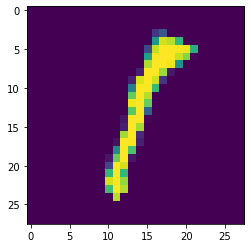

In [ ]:
plt.imshow(reconstructed_model.predict(latent_points).reshape((28,28)))